# Decision Making Under Uncertainty - Assignment 2

Group 2:
- Martijn Ketelaars (ANR: 120975)
- Robbie Reyerse (ANR: 109997)
- Rosalien Timmerhuis (ANR: 520618)
- Mike Weltevrede (ANR: 756479)

## Exercise b.
Write for this extended system a discrete-event simulation. In order to do this, you might need object-oriented programming.

In [1]:
verbose = True

import statistics
from collections import deque

import heapq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
class Customer :

    def __init__(self, arrivalTime, priority):
        self.arrivalTime = arrivalTime
        self.serviceTime = 0
        self.systemArrivalTime = arrivalTime
        self.priority = priority
        self.NQW = 0 #NQW = needy queue waiting time
        self.needyArrivalTime = 0   #a customer arrives only one time in the system
        self.needyQueueArrivalTime = 0
        self.enterClosedSystemTime = 0
        
        # location: holding, needy, content, out, queue_needy
        self.location = 'holding'
        
    def moveTo(self, location, time, newServiceTime):
        
        assert location.lower() in {'holding', 'needy', 'content', 'out', 'queue_needy'},\
            "Not a proper location. Location should be holding, needy, content, out, or queue_needy"
        
        if self.location.lower() == "holding":
            self.needyArrivalTime = time
        
        if location.lower() == "queue_needy":
            self.needyQueueArrivalTime = time
            
        self.location = location.lower()
        self.arrivalTime = time
        self.serviceTime = newServiceTime
        
    def enterClosedSystem(self,time):
        self.enterClosedSystemTime = time
        
    def leaveSystem(self,time):
        self.location = 'out'
        self.serviceTime = -1
        self.sojournTime = time - self.enterClosedSystemTime
        

In [3]:
class Event:

    ARRIVAL = 'ARRIVAL'
    DEPARTURE = 'DEPARTURE'
    
    def __init__(self, typ, time, cust): 
        self.type = typ
        self.time = time
        self.customer = cust
        
    def __lt__(self, other):
        return self.time < other.time
    

In [4]:
class FES :
    
    def __init__(self):
        self.events = []
        
    def add(self, event):
        heapq.heappush(self.events, event)
        
    def next(self):
        return heapq.heappop(self.events)
    

In [5]:
class NeedyServer:
    
    def __init__(self, servDist, nrServers=2):
        self.servDist = servDist
        self.nrServers = nrServers
        
        # Number of customers at this server, not including queue
        self.number_of_customers = 0
        
    def __len__(self):
        return self.number_of_customers
        
class ContentServer:
    
    def __init__(self, servDist):
        self.servDist = servDist
        self.number_of_customers = 0
    
    def __len__(self):
        return self.number_of_customers
    

In [6]:
class SimulationResults:

    def __init__(self):
        self.results = {}
        self.number_of_arrivals = {'high': 0, 'low': 0}
        self.number_of_arrivals_waiting = {'high': 0, 'low': 0}
        self.meanNeedyQueueLength = 0
        self.total_needy_queue_length = 0
        self.number_in_system = {'N': [], 't': []}
        self.sojournTimeList = []
        self.totalTimeInSystemList = []
        self.totalTimeInSystemBurnInList = [] 
        self.needyWaitingTimeList = []
        self.holdingTimeList = {'high_priority': [],
                                'low_priority': []}

    def registerHoldingTime(self, holdingTime, priority):
        if priority == 'high':
            self.holdingTimeList['high_priority'].append(holdingTime)
        else:
            self.holdingTimeList['low_priority'].append(holdingTime)
            
    def registerSojournTime(self, sojournTime):
        self.sojournTimeList.append(sojournTime)
        
    def registerSojournTimeWithBurnIn(self, sojournTime):
        self.sojournTimeListWithBurnIn.append(sojournTime)

    def registerNeedyWaitingTime(self, needyWaitingTime):
        self.needyWaitingTimeList.append(needyWaitingTime)

    def registerArrival(self, priority, waiting=False):
        self.number_of_arrivals[priority] += 1

        if waiting:
            self.number_of_arrivals_waiting[priority] += 1
    
    def registerNumberInSystem(self, N, time):
        self.number_in_system['N'].append(N)
        self.number_in_system['t'].append(time)
    
    def registerNeedyQueueLength(self, length):
        self.total_needy_queue_length += length

    def updateMeanNeedyQueueLength(self, t, t0, queue_needy, finalise=False):
        if finalise:
            self.meanNeedyQueueLength /= t
        else:
            # We add to the sum as on Slide 15 of Week 8.
            self.meanNeedyQueueLength += (len(queue_needy) * (t - t0))
        
    def getMeanSojournTime(self):
        return np.mean(self.sojournTimeList)

    def getMeanWaitingTime(self):
        return np.mean(self.needyWaitingTimeList)
    
    def calculateBlockingProbability(self):
        # number of arrivals that have to wait in holding / total number of arrivals

        self.results['blocking_probability'] = \
            {priority: self.number_of_arrivals_waiting[priority] / self.number_of_arrivals[priority]
             for priority in ('high', 'low')}
        self.results['blocking_probability']['total'] = \
            sum(self.number_of_arrivals_waiting.values()) / sum(self.number_of_arrivals.values())
            
    def getCustomerSojournTime(self):
        return self.sojournTimeListWithBurnIn
    
    def registerTotalTimeInSystem(self, totalTimeInSystem):
        self.totalTimeInSystemList.append(totalTimeInSystem)
        
    def getTotalTimeInSystem(self):
        return self.totalTimeInSystemList
    
    def registerTotalTimeInSystemBurnIn(self, totalTimeInSystemBurnIn):
        self.totalTimeInSystemBurnInList.append(totalTimeInSystemBurnIn)
        
    def getTotalTimeInSystemBurnIn(self):
        return self.totalTimeInSystemBurnInList
        

In [7]:
class Network:
    
    def __init__(self, lambda_L, lambda_H, servDist_needy, nrServers, servDist_content, N, p, mu=1):
        self.arrDist = stats.expon(scale=1/(lambda_L+lambda_H))
        self.high_priority_probability = lambda_H/(lambda_L+lambda_H) # probability for high
        self.N = N
        self.p = p
        self.nrServers = nrServers
        
        # Check stability
        if lambda_L + lambda_H > nrServers*mu*(1-p):
            print("WARNING: This system is not stable. Take caution c:")
        
        # Create servers
        self.NeedyServer = NeedyServer(servDist_needy, nrServers)
        self.ContentServer = ContentServer(servDist_content)
        self.simresults = SimulationResults()
        
    def simulate(self, T, burn_in_period=None):
        
        # If burn-in period is not specified, take 10% of T, rounded down
        if burn_in_period is None:
            burn_in_period = T // 10
        
        t0 = 0   # initial ti-1 for calculating mean needy queue
        t = 0 # initialise time
        total_needy_queue = 0
        
        fes = FES() 
        
        queue_holding_high = deque() # the holding queue for high priority
        queue_holding_low = deque()  # the holding queue for low priority
        queue_needy = deque()        # the queue for needy server
        res = SimulationResults()
        
        # Generate arrival of the first customer
        u = stats.uniform().rvs()
        
        if u < self.high_priority_probability:
            c0 = Customer(self.arrDist.rvs(), priority='high')
            
        else:
            c0 = Customer(self.arrDist.rvs(), priority='low')
            
        firstEvent = Event(Event.ARRIVAL, c0.arrivalTime, c0)
        fes.add(firstEvent) # schedule first arrival event
        
        while t < T:
            burn_in = (t < burn_in_period)
            
            e = fes.next()                      # jump to next event
            t = e.time                          # update the time
            c1 = e.customer                     # customer associated with this event
            
            number_in_system = len(queue_needy) + len(self.NeedyServer) + len(self.ContentServer)
            self.simresults.registerNumberInSystem(number_in_system, t)
            
            if not burn_in:
                # Add the inner part of the sum on Week 8, Slide 15
                self.simresults.updateMeanNeedyQueueLength(t, t0, queue_needy)
                t0 = t # Update t_i-1 to t_i
                
                # Update total number of people that had to wait in the needy queue
                self.simresults.registerNeedyQueueLength(length=len(queue_needy))

            if e.type == 'ARRIVAL':
                
                if c1.location == 'holding':
                    
                    if number_in_system < self.N:
                        
                        # Admit this customer to the closed system
                        c1.enterClosedSystem(t)
                        
                        if len(self.NeedyServer) < self.NeedyServer.nrServers:
                            
                            # Admit this customer directly to the needy server
                            serviceTime = self.NeedyServer.servDist.rvs()
                            c1.moveTo('needy', t, serviceTime)
                            
                            # Update number of customers at needy server
                            self.NeedyServer.number_of_customers += 1
                            
                            dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                            fes.add(dep)

                        else:
                            # Add to queue for needy server, independent of priority
                            queue_needy.append(c1)
                            c1.moveTo('queue_needy', t, _)

                        if not burn_in:
                            self.simresults.registerArrival(priority=c1.priority)
                            
                    else:
                        # They cannot be directly admitted to the closed system.
                        # Add to holding queue
                        if c1.priority == 'high':
                            queue_holding_high.append(c1)
                        else:
                            queue_holding_low.append(c1)
                            
                        if not burn_in:
                            self.simresults.registerArrival(priority=c1.priority, waiting=True)

                    # Schedule new arrival
                    u = stats.uniform().rvs()

                    if u < self.high_priority_probability:
                        c2 = Customer(t + self.arrDist.rvs(), priority='high')
                    else:
                        c2 = Customer(t + self.arrDist.rvs(), priority='low')

                    arrival = Event(Event.ARRIVAL, c2.arrivalTime, c2)
                    fes.add(arrival)
                else:
                    raise Exception("ERROR: Arrival from", c1.location)
                
            elif e.type == 'DEPARTURE':
                
                if c1.location == 'content':
                    
                    # Update number of customers at needy server
                    self.ContentServer.number_of_customers -= 1
                    
                    if len(self.NeedyServer) < self.NeedyServer.nrServers:
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c1.moveTo('needy', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                    else:
                        queue_needy.append(c1)
                        c1.moveTo('queue_needy', t, _)
                        
                elif c1.location == 'needy':
                    
                    # Update number of customers at needy server - someone leaves
                    self.NeedyServer.number_of_customers -= 1
                    
                    # Admit person from needy queue, if nonempty
                    if len(queue_needy) > 0:
                        c2 = queue_needy.popleft()
                        
                        if not burn_in:
                            self.simresults.registerNeedyWaitingTime(t - c2.needyQueueArrivalTime)
                        
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c2.moveTo('needy', t, serviceTime)

                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1

                        dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                        fes.add(dep)
                    
                    # Check if leaves or goes to content
                    u = stats.uniform().rvs()

                    if u < self.p:
                        # Go to content
                        serviceTime = self.ContentServer.servDist.rvs()
                        c1.moveTo('content', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.ContentServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                        
                    else:
                        # Leave system
                        # Set c1.location to 'out', c1.serviceTime to -1, and calculate sojourn time
                        c1.leaveSystem(t) 

                        self.simresults.registerTotalTimeInSystemBurnIn(t-c1.systemArrivalTime)
                        
                        if not burn_in:
                            self.simresults.registerSojournTime(c1.sojournTime)
                            self.simresults.registerTotalTimeInSystem(t-c1.systemArrivalTime)
                        
                        # Admit someone from holding queue
                        if len(queue_holding_high) > 0:
                            c2 = queue_holding_high.popleft()
                            c2.enterClosedSystem(t)
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                                
                            if not burn_in:
                                self.simresults.registerHoldingTime(c2.needyArrivalTime - c2.systemArrivalTime,
                                                                    c2.priority)
                            
                        elif len(queue_holding_low) > 0:
                            c2 = queue_holding_low.popleft()
                            c2.enterClosedSystem(t)
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                                
                            if not burn_in:
                                self.simresults.registerHoldingTime(c2.enterClosedSystemTime - c2.systemArrivalTime,
                                                                    c2.priority)
                        else:
                            pass  
                        
                else:
                    raise Exception("ERROR: Departure from", c1.location)
        
        self.simresults.updateMeanNeedyQueueLength(t, _, _, finalise=True)
        

In [8]:
np.random.seed(1)
T = 10000

# Initialise arguments (benchmark case)
lambda_L = 0.5
lambda_H = 0.25
nrServers = 2
mu = 1
p = 0.4
delta = 1
N = 5

servDist_needy = stats.expon(scale=float(1/mu))
servDist_content = stats.expon(scale=float(1/delta))


In [9]:
sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
              servDist_content, N, p)

sim.simulate(T)


C:\Users\mikew\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\mikew\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


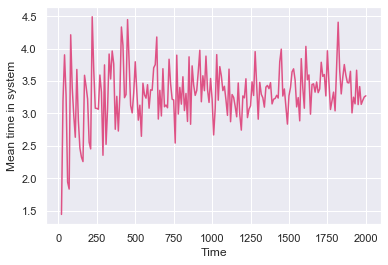

In [10]:
# Determine burn in period with average sojourn time in system
t_runs = 200
averageTimeInSystem = np.zeros(t_runs)
t_run_spacing = np.linspace(10,2000,t_runs)

for t in range(t_runs):
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
              servDist_content, N, p)    
    sim.simulate(t_run_spacing[t])
    averageTimeInSystem[t] = np.mean(sim.simresults.totalTimeInSystemBurnInList)
     

plt.plot(t_run_spacing,averageTimeInSystem, color='#de5285')
plt.xlabel("Time")
plt.ylabel("Mean time in system")
plt.show()


## Exercise c.
Use your discrete-event simulation to present performance measures (perhaps probability of blocking for the different customer priority classes, probability of waiting, mean queue length, mean waiting time,...) for the extended system for different values of $\lambda_L$, $\lambda_H$, and $\delta$, and different values of $N$. Elaborate on your findings by creating a comprehensive management report including several sensitivity analyses.

In [11]:
np.random.seed(1)
sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
              servDist_content, N, p)

sim.simulate(T)


In [34]:
sim.simresults.calculateBlockingProbability()
print(f"Blocking Probability: {sim.simresults.results['blocking_probability']} \n")

print(f"Mean Needy Queue Length: {sim.simresults.meanNeedyQueueLength}")
print(f"Mean Needy Queue Waiting Time: {sim.simresults.getMeanWaitingTime()} \n")

ht = sim.simresults.holdingTimeList.values()["high"]
print(f"{len(ht)} high priority customers had to wait in the holding queue "
      f"for a mean time of {np.mean(ht)}")
ht = sim.simresults.holdingTimeList.values()["low"]
print(f"{len(ht)} low priority customers had to wait in the holding queue "
      f"for a mean time of {np.mean(ht)}")
    
print(f"\nMean Sojourn Time: {sim.simresults.getMeanSojournTime()}")


Blocking Probability: {'high': 0.0, 'low': 0.0, 'total': 0.0} 

Mean Needy Queue Length: 0.7866723631352888
Mean Needy Queue Waiting Time: 1.2872835750397502 



TypeError: 'dict_values' object is not subscriptable

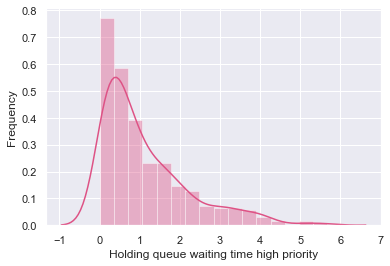

The mean waiting time for is equal to 1.1151683419164093


In [13]:
sns.distplot(sim.simresults.holdingTimeList['high_priority'], color='#de5285')
plt.xlabel("Holding queue waiting time high priority")
plt.ylabel("Frequency")
plt.show()

print("The mean waiting time for is equal to", np.mean(sim.simresults.holdingTimeList['high_priority']))


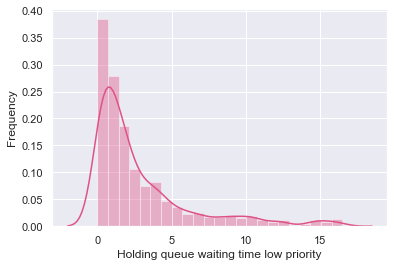

The mean waiting time is equal to 2.8802931478203253


In [14]:
sns.distplot(sim.simresults.holdingTimeList['low_priority'], color='#de5285')
plt.xlabel("Holding queue waiting time low priority")
plt.ylabel("Frequency")
plt.show()

print("The mean waiting time is equal to", np.mean(sim.simresults.holdingTimeList['low_priority']))


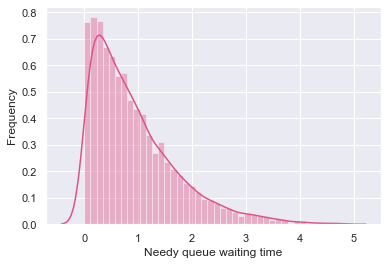

The mean waiting time is equal to 0.9299246754133755


In [15]:
sns.distplot(sim.simresults.needyWaitingTimeList, color='#de5285')
plt.xlabel("Needy queue waiting time")
plt.ylabel("Frequency")
plt.show()

print("The mean waiting time is equal to", np.mean(sim.simresults.needyWaitingTimeList))


#### Blocking probability changing $\lambda$ 

In [16]:
#changing lambda L (and thus fix lambda H)
np.random.seed(1)
runs = 30
T = 10000

# Specify which values for lambda_L to test
lambda_H_temp = 1/100
lambda_L_array = np.linspace(lambda_H_temp, (1-p)*nrServers*mu-lambda_H_temp, runs)
lambda_L_temp = lambda_L

probabilities_total = np.zeros(runs)
probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    lambda_L = lambda_L_array[i]
    sim = Network(lambda_L, lambda_H_temp, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    sim.simresults.calculateBlockingProbability()
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability for lambda_L equal to", lambda_L)
        print("Blocking probability:", sim.simresults.results['blocking_probability'])
        print("")
    
    probabilities_total[i] = sim.simresults.results['blocking_probability']['total']
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']
    
# Reset lambda_L
lambda_L = lambda_L_temp


Probability for lambda_L equal to 0.01
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.05068965517241379
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.09137931034482757
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.13206896551724137
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.17275862068965517
Blocking probability: {'high': 0.0, 'low': 0.0, 'total': 0.0}

Probability for lambda_L equal to 0.21344827586206896
Blocking probability: {'high': 0.0, 'low': 0.0010162601626016261, 'total': 0.0009704027171276079}

Probability for lambda_L equal to 0.25413793103448273
Blocking probability: {'high': 0.0, 'low': 0.0034587116299178555, 'total': 0.0033181252592285357}

Probability for lambda_L equal to 0.29482758620689653
Blocking probability: {'high': 0.0, 'low': 0.004107542942494399, 'tota

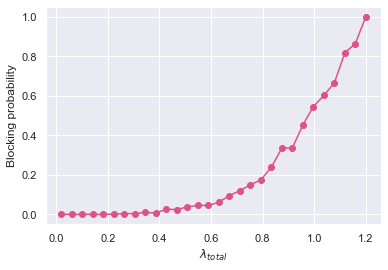

In [17]:
plt.plot(lambda_L_array+lambda_H_temp, probabilities_total, marker='o', color='#de5285')

plt.xlabel('$\lambda_{total}$')
plt.ylabel('Blocking probability')
plt.show()


#### Blocking probability changing $\delta$ 

In [18]:
np.random.seed(1)

# Specify which values for delta to test
smooth_range = 3

delta_temp = delta
delta_array = np.linspace(1, 4*nrServers*mu, runs)

probabilities_total = np.zeros(runs)
probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

probs = {key: [] for key in delta_array}

for j in range(smooth_range):
    for i in range(runs):
        delta = delta_array[i]
        servDist_content = stats.expon(scale=float(1/delta))

        sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                      servDist_content, N, p)
        sim.simulate(T)
        sim.simresults.calculateBlockingProbability()

        if verbose:
            # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
            print("Probability for delta equal to", delta)
            print("Blocking probability:", sim.simresults.results['blocking_probability'])
            print("")

        probabilities_total[i] = sim.simresults.results['blocking_probability']['total']
        probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
        probabilities_low[i] = sim.simresults.results['blocking_probability']['low']
    
        probs[delta].append(sim.simresults.results['blocking_probability']['total'])
    
# Reset to original values
delta = delta_temp
servDist_content = stats.expon(scale=float(1/delta))


Probability for delta equal to 1.0
Blocking probability: {'high': 0.14993592481845366, 'low': 0.14314652261985145, 'total': 0.14548938679245282}

Probability for delta equal to 1.2413793103448276
Blocking probability: {'high': 0.16456247279059644, 'low': 0.16863001745200698, 'total': 0.16727219880831273}

Probability for delta equal to 1.4827586206896552
Blocking probability: {'high': 0.13556338028169015, 'low': 0.13847874720357942, 'total': 0.1374962919015129}

Probability for delta equal to 1.7241379310344827
Blocking probability: {'high': 0.12122641509433962, 'low': 0.13364569388665773, 'total': 0.12965767949106333}

Probability for delta equal to 1.9655172413793105
Blocking probability: {'high': 0.1658600967883854, 'low': 0.16195037004788854, 'total': 0.16324450269404397}

Probability for delta equal to 2.206896551724138
Blocking probability: {'high': 0.13218884120171673, 'low': 0.13953488372093023, 'total': 0.13700251516496523}

Probability for delta equal to 2.4482758620689653
Bl

Probability for delta equal to 6.310344827586207
Blocking probability: {'high': 0.09391534391534391, 'low': 0.10938204781235904, 'total': 0.10414801551775589}

Probability for delta equal to 6.551724137931035
Blocking probability: {'high': 0.1653966831017481, 'low': 0.1458099303527297, 'total': 0.15234959592936248}

Probability for delta equal to 6.793103448275862
Blocking probability: {'high': 0.1171011931064958, 'low': 0.12089124200308846, 'total': 0.1196291936433196}

Probability for delta equal to 7.0344827586206895
Blocking probability: {'high': 0.11541850220264317, 'low': 0.11539313399778516, 'total': 0.11540162122328666}

Probability for delta equal to 7.275862068965518
Blocking probability: {'high': 0.12666973744818055, 'low': 0.12283044058744993, 'total': 0.12408102025506376}

Probability for delta equal to 7.517241379310345
Blocking probability: {'high': 0.14285714285714285, 'low': 0.13829321663019695, 'total': 0.1398100803506209}

Probability for delta equal to 7.75862068965

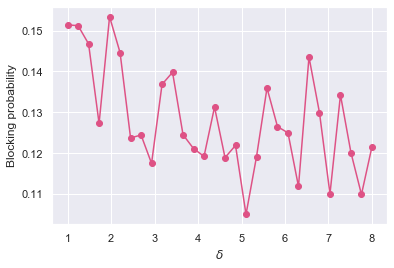

In [19]:
plt.plot(delta_array, list([np.mean(probs[x]) for x in probs]), marker='o', color='#de5285', label="Total")

plt.xlabel('$\delta$')
plt.ylabel('Blocking probability')
plt.show()


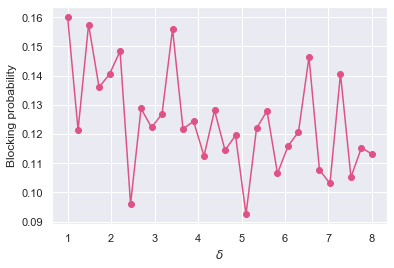

In [20]:
plt.plot(delta_array, probabilities_total, marker='o', color='#de5285', label="Total")

plt.xlabel('$\delta$')
plt.ylabel('Blocking probability')
plt.show()


#### Needy queue length changing $p$

In [21]:
# Changing p (comparing the needy queue length)
np.random.seed(1)

p_temp = p
p_array = np.linspace(0.01, 0.99, runs)
mean_queue_length = np.zeros(runs)

for i in range(runs):
    p = p_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    
    mean_needy = sim.simresults.meanNeedyQueueLength
    
    if verbose:
        print("Probability of not leaving system equal to", p)
        print("Mean queue length: ", mean_needy)
        print("")
    
    mean_queue_length[i] = mean_needy
    
p = p_temp


Probability of not leaving system equal to 0.01
Mean queue length:  0.30413097271392836

Probability of not leaving system equal to 0.04379310344827586
Mean queue length:  0.1341306932440229

Probability of not leaving system equal to 0.07758620689655171
Mean queue length:  0.1417735677949484

Probability of not leaving system equal to 0.11137931034482758
Mean queue length:  0.1574523620286879

Probability of not leaving system equal to 0.14517241379310344
Mean queue length:  0.1792224772567899

Probability of not leaving system equal to 0.1789655172413793
Mean queue length:  0.4974451542239184

Probability of not leaving system equal to 0.21275862068965518
Mean queue length:  0.25193092044065024

Probability of not leaving system equal to 0.24655172413793103
Mean queue length:  0.22872146558975195

Probability of not leaving system equal to 0.2803448275862069
Mean queue length:  0.2757073793480034

Probability of not leaving system equal to 0.31413793103448273
Mean queue length:  0.49

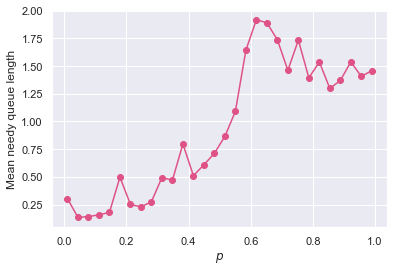

In [22]:
plt.plot(p_array, mean_queue_length, marker='o', color='#de5285')
plt.xlabel('$p$')
plt.ylabel('Mean needy queue length')
plt.show()


#### Mean needy queue length changing $N$

In [23]:
# Changing N (comparing the needy queue length)
np.random.seed(1)

N_temp = N

# Specify which values for N to test
N_array = np.linspace(5, 1000, runs)
mean_queue_length = np.zeros(runs)

for i in range(runs):
    N = N_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)  #change lambda here
    sim.simulate(T)
        
    mean_needy = sim.simresults.meanNeedyQueueLength

    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print(f"N={N} - Mean queue length = {mean_needy}")
        print("")
    
    mean_queue_length[i] = mean_needy

N = N_temp


N=5.0 - Mean queue length = 0.4896224667870534

N=39.310344827586206 - Mean queue length = 0.7303375328160784

N=73.62068965517241 - Mean queue length = 0.6078826327236785

N=107.93103448275862 - Mean queue length = 0.7576913292332472

N=142.24137931034483 - Mean queue length = 1.0178190216820386

N=176.55172413793105 - Mean queue length = 0.6627998446340425

N=210.86206896551724 - Mean queue length = 1.0426944902717274

N=245.17241379310343 - Mean queue length = 0.6777437233241862

N=279.48275862068965 - Mean queue length = 0.6478575082550535

N=313.7931034482759 - Mean queue length = 0.6405495305669106

N=348.1034482758621 - Mean queue length = 1.0947806815943297

N=382.41379310344826 - Mean queue length = 0.6694267724920775

N=416.7241379310345 - Mean queue length = 0.7335536559891238

N=451.0344827586207 - Mean queue length = 0.6690183915081135

N=485.34482758620686 - Mean queue length = 0.8315418280369581

N=519.6551724137931 - Mean queue length = 0.758106758064842

N=553.96551724

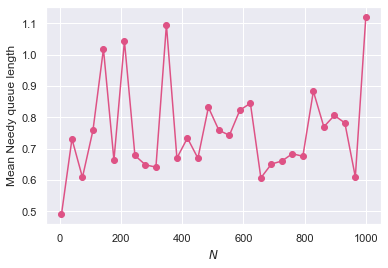

In [24]:
plt.plot(N_array, mean_queue_length, marker='o', color='#de5285')
plt.xlabel('$N$')
plt.ylabel('Mean Needy queue length')
plt.show()


In [25]:
# Changing N (comparing the mean sojourn time)
np.random.seed(1)

N_temp = N

# Specify which values for N to test
N_array = np.linspace(5, 1000, runs)
mean_sojourn_length = np.zeros(runs)

for i in range(runs):
    N = N_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)  
    sim.simulate(T)
        
    mean_sojourn = np.mean(sim.simresults.sojournTimeList)

    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print(f"N={N} - Mean sojourn time = {mean_sojourn}")
        print("")
    
    mean_sojourn_length[i] = mean_sojourn

N = N_temp


N=5.0 - Mean sojourn time = 3.051256207625729

N=39.310344827586206 - Mean sojourn time = 3.407936194085888

N=73.62068965517241 - Mean sojourn time = 3.225177728697563

N=107.93103448275862 - Mean sojourn time = 3.3262398046748722

N=142.24137931034483 - Mean sojourn time = 3.5045558357035325

N=176.55172413793105 - Mean sojourn time = 3.2822967175574864

N=210.86206896551724 - Mean sojourn time = 3.618355606971666

N=245.17241379310343 - Mean sojourn time = 3.260308197158347

N=279.48275862068965 - Mean sojourn time = 3.2461716445417466

N=313.7931034482759 - Mean sojourn time = 3.247048992933051

N=348.1034482758621 - Mean sojourn time = 3.330751248071036

N=382.41379310344826 - Mean sojourn time = 3.3306505771086616

N=416.7241379310345 - Mean sojourn time = 3.387261938380283

N=451.0344827586207 - Mean sojourn time = 3.3270633798646347

N=485.34482758620686 - Mean sojourn time = 3.622930701426245

N=519.6551724137931 - Mean sojourn time = 3.461677722993415

N=553.9655172413793 - M

In [26]:
# Changing p (comparing the mean sojourn time)
np.random.seed(1)

p_temp = p

# Specify which values for N to test
p_array = np.linspace(0.01, 0.8, runs)
mean_sojourn_length = np.zeros(runs)

for i in range(runs):
    p = p_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)  
    sim.simulate(T)
        
    mean_sojourn = np.mean(sim.simresults.sojournTimeList)

    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print(f"p={p} - Mean sojourn time = {mean_sojourn}")
        print("")
    
    mean_sojourn_length[i] = mean_sojourn

p = p_temp


p=0.01 - Mean sojourn time = 1.1570481074903853

p=0.03724137931034483 - Mean sojourn time = 1.2755229665173948

p=0.06448275862068965 - Mean sojourn time = 1.3721739261189865

p=0.09172413793103448 - Mean sojourn time = 1.4421789458894836

p=0.11896551724137931 - Mean sojourn time = 1.4699644841489825

p=0.14620689655172414 - Mean sojourn time = 1.5441208246228526

p=0.17344827586206898 - Mean sojourn time = 1.6867676041014439

p=0.20068965517241383 - Mean sojourn time = 1.8178083795281281

p=0.22793103448275864 - Mean sojourn time = 2.0155861260920873

p=0.25517241379310346 - Mean sojourn time = 2.061830512007924

p=0.2824137931034483 - Mean sojourn time = 2.230015722914379

p=0.30965517241379314 - Mean sojourn time = 2.363177744466106

p=0.33689655172413796 - Mean sojourn time = 2.5880384896991506

p=0.3641379310344828 - Mean sojourn time = 2.6655041071982724

p=0.39137931034482765 - Mean sojourn time = 2.961711652797074

p=0.41862068965517246 - Mean sojourn time = 3.091363749059652

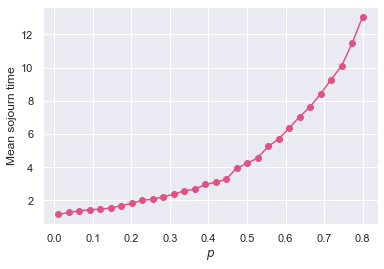

In [27]:
plt.plot(p_array, mean_sojourn_length, marker='o', color='#de5285')
plt.xlabel('$p$')
plt.ylabel('Mean sojourn time')
plt.show()


#### Mean queue length as $\delta$ changes

In [28]:
np.random.seed(1)

delta_temp = delta
delta_array = np.linspace(1, 4*nrServers*mu, runs)

mean_queue_length_delta = np.zeros(runs)

for i in range(runs):
    delta = delta_array[i]
    servDist_content = stats.expon(scale=float(1/delta))
        
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    
    mean_needy = sim.simresults.meanNeedyQueueLength
    
    if verbose:
        print("Probability of not leaving system equal to", p)
        print("Mean queue length: ", mean_needy)
        print("")
    
    mean_queue_length_delta[i] = mean_needy
    
delta = delta_temp

Probability of not leaving system equal to 0.4
Mean queue length:  0.4896224667870534

Probability of not leaving system equal to 0.4
Mean queue length:  0.5392186774779338

Probability of not leaving system equal to 0.4
Mean queue length:  0.5013741020316499

Probability of not leaving system equal to 0.4
Mean queue length:  0.483285642585904

Probability of not leaving system equal to 0.4
Mean queue length:  0.5900071908621122

Probability of not leaving system equal to 0.4
Mean queue length:  0.5320443218063379

Probability of not leaving system equal to 0.4
Mean queue length:  0.5352611323010484

Probability of not leaving system equal to 0.4
Mean queue length:  0.5015956968965302

Probability of not leaving system equal to 0.4
Mean queue length:  0.46900715695487183

Probability of not leaving system equal to 0.4
Mean queue length:  0.5420453901817206

Probability of not leaving system equal to 0.4
Mean queue length:  0.8115335270945232

Probability of not leaving system equal to 

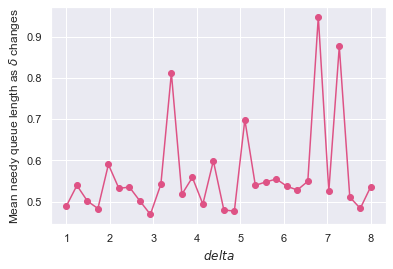

In [29]:
plt.plot(delta_array, mean_queue_length_delta, marker='o', color='#de5285')
plt.xlabel('$delta$')
plt.ylabel('Mean needy queue length as $\delta$ changes')
plt.show()


## Exercise d.
Investigate the difference in performance between the original system ($N = 1$) and the extended system (finite $N$). For instance, how fast does the behavior of the extended system mimic the original system behavior as $N$ increases?

#### Mean total time in system as $N$ increases

In [30]:
# Changing N (comparing the mean sojourn time)
np.random.seed(1)

N_temp = N

runs = 21

# Specify which values for N to test
N_array = np.linspace(1, runs, runs)
meanHoldingQueueWaitingLow = np.zeros(runs)
meanHoldingQueueWaitingHigh= np.zeros(runs)
blockingProbability_N = np.zeros(runs)

for i in range(runs):
    N = N_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)  
    sim.simulate(T)
    sim.simresults.calculateBlockingProbability()
    
    blockingProbability_N[i] = sim.simresults.results['blocking_probability']['total']
    
       
    meanHoldingQueueWaitingLow[i] = np.mean(sim.simresults.holdingTimeList['low_priority'])
    meanHoldingQueueWaitingHigh[i] = np.mean(sim.simresults.holdingTimeList['high_priority'])
    
N = N_temp

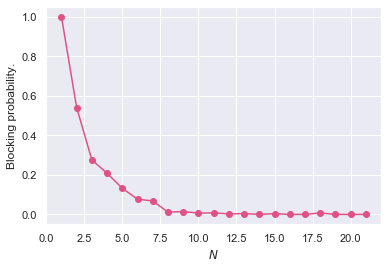

In [31]:
plt.plot(N_array, blockingProbability_N, marker='o', color='#de5285')
plt.xlabel('$N$')
plt.ylabel('Blocking probability.')
plt.show()


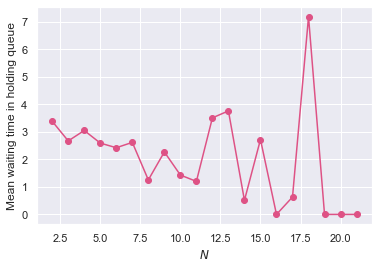

In [32]:
meanHoldingQueueWaitingLow[np.isnan(meanHoldingQueueWaitingLow)] = 0

plt.plot(N_array[1:runs], meanHoldingQueueWaitingLow[1:runs], marker='o', color='#de5285')
plt.xlabel('$N$')
plt.ylabel('Mean waiting time in holding queue')
plt.show()

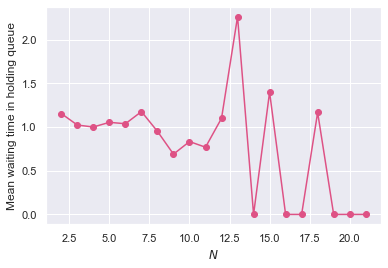

In [33]:
meanHoldingQueueWaitingHigh[np.isnan(meanHoldingQueueWaitingHigh)] = 0

plt.plot(N_array[1:runs], meanHoldingQueueWaitingHigh[1:runs], marker='o', color='#de5285')
plt.xlabel('$N$')
plt.ylabel('Mean waiting time in holding queue')
plt.show()
